In [78]:
import numpy as np
import pandas as pd
from datetime import date,timedelta

%matplotlib inline
import matplotlib.pyplot as plt

In [79]:
customer_ds = pd.read_csv('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/olist_customers_dataset.csv')
oder_ds = pd.read_csv('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/olist_orders_dataset.csv')
payment_ds = pd.read_csv('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/olist_order_payments_dataset.csv')

In [80]:
data = pd.merge(customer_ds, oder_ds, on='customer_id', how='outer')
data = pd.merge(data, payment_ds, on='order_id', how='outer')

In [81]:
data =data.drop(columns=['customer_unique_id','customer_zip_code_prefix','customer_city','customer_state','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','payment_type','payment_installments'])

In [82]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [83]:
end_date=pd.to_datetime(data['order_purchase_timestamp'].max(), format=None).to_period('D').to_timestamp()
start_date=pd.to_datetime(data['order_purchase_timestamp'].min(), format=None).to_period('D').to_timestamp()
print("Start Date : ",start_date)
print("End Date : ",end_date)

Start Date :  2016-09-04 00:00:00
End Date :  2018-10-17 00:00:00


In [84]:
#considering 04-09-2016 to 2017-09-24 as training data
#considering 2017-09-25 to 17-10-2018 as testing data
#delta=(end_date-start_date)/2
#delta.days
#start_date + timedelta(delta.days)
split_date=start_date + timedelta(((end_date-start_date)/2).days)
print("Split Date : ",split_date)

Split Date :  2017-09-25 00:00:00


In [85]:
train=data.loc[(data.order_purchase_timestamp >= start_date) & (data.order_purchase_timestamp <= split_date)]
test=data.loc[(data.order_purchase_timestamp > split_date) & (data.order_purchase_timestamp <= end_date)]

In [86]:
train

,customer_id,order_id,order_status,order_purchase_timestamp,payment_sequential,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1.0,146.87
5,879864dab9bc3047522c92c82e1212b8,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,1.0,282.21
12,b2d1536598b73a9abd18e0d75d92f0a3,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,1.0,117.31
18,9b8ce803689b3562defaad4613ef426f,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2.0,34.05
19,9b8ce803689b3562defaad4613ef426f,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,1.0,67.98
...,...,...,...,...,...,...
103866,e5ed7280cd1a3ac2ba29fd6650d8867c,53cbf33b674d602f6746cb90a9d874fd,delivered,2017-05-15 17:42:38,1.0,102.03
103872,ffa6d90c36a9c7004692ca50761c69d6,2816b0ec050fb4a136c32a6bda007a91,delivered,2017-03-27 16:26:18,1.0,130.85
103875,27b9b32173455ef32167540451749d0b,326c29ec5b89834b17aea7d85302fd70,delivered,2017-05-24 11:54:31,1.0,102.03
103878,14308d2303a3e2bdf4939b86c46d2679,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2.0,40.53


In [87]:
def cal_RFM(df,customer):
    period_end=pd.to_datetime(df['order_purchase_timestamp'].max(), format=None).to_period('D').to_timestamp()
    #local_df = pd.DataFrame(data[cust_col].unique())
    #local_df.columns = [cust_col]

    #get the max purchase date for each customer and create a dataframe with it
    recency = df.groupby('customer_id').order_purchase_timestamp.max().reset_index()
    recency.columns = ['customer_id','MaxOrderdate']

    #we take our observation point as the max invoice date in our dataset
    recency['Recency'] = (recency['MaxOrderdate'].max() - recency['MaxOrderdate']).dt.days
    
    #merge this dataframe to our new user dataframe
    customer = pd.merge(customer, recency[['customer_id','Recency']], on='customer_id')
    
    frequency = df.groupby('customer_id').order_purchase_timestamp.count().reset_index()
    frequency.columns = ['customer_id','Frequency']
    customer = pd.merge(customer, frequency, on='customer_id')
    
    payment = df.groupby('customer_id').payment_value.sum().reset_index()
    payment.columns = ['customer_id','Payment']
    customer = pd.merge(customer, payment, on='customer_id')
    return customer

In [92]:
customer_train=pd.DataFrame(train['customer_id'].unique())
customer_train.columns = ['customer_id']
customer_train=cal_RFM(train,customer_train)

In [93]:
customer_train

,customer_id,Recency,Frequency,Payment
0,06b8999e2fba1a1fbc88172c00ba8bc7,131,1,146.87
1,879864dab9bc3047522c92c82e1212b8,10,1,282.21
2,b2d1536598b73a9abd18e0d75d92f0a3,15,1,117.31
3,9b8ce803689b3562defaad4613ef426f,136,2,102.03
4,154c4ded6991bdfa3cd249d11abf4130,42,1,123.00
...,...,...,...,...
26741,be631308cb609ff74d0e0fb54815e18c,242,1,64.42
26742,e5ed7280cd1a3ac2ba29fd6650d8867c,132,1,102.03
26743,ffa6d90c36a9c7004692ca50761c69d6,181,1,130.85
26744,27b9b32173455ef32167540451749d0b,123,1,102.03


In [94]:
customer_test=pd.DataFrame(test['customer_id'].unique())
customer_test.columns = ['customer_id']
customer_test=cal_RFM(test,customer_test)

In [95]:
customer_test

,customer_id,Recency,Frequency,Payment
0,18955e83d337fd6b2def6b18a428ac77,276,1,335.48
1,4e7b3e00288586ebd08712fdd0374a03,150,1,157.73
2,b2b6027bc5c5109e529d4dc6358b12c3,217,1,173.30
3,4f2d8ab171c80ec8364f7c12e35b23ad,79,1,252.25
4,fd826e7cf63160e536e0908c76c3f441,239,1,22.77
...,...,...,...,...
72689,17ddf5dd5d51696bb3d7c6291687be6f,192,1,88.78
72690,e7b71a9017aa05c9a7fd292d714858e8,195,1,129.06
72691,5e28dfe12db7fb50a4b2f691faecea5e,191,1,56.04
72692,56b18e2166679b8a959d72dd06da27f9,346,1,711.07


In [97]:
cltv_train = customer_train.groupby('customer_id')['Payment'].sum().reset_index()
cltv_train.columns = ['customer_id','Payment']

(array([1.000e+00, 1.900e+01, 2.330e+02, 8.360e+02, 1.374e+03, 1.394e+03,
        1.368e+03, 1.456e+03, 1.419e+03, 1.454e+03, 1.278e+03, 1.119e+03,
        9.370e+02, 1.044e+03, 8.640e+02, 9.260e+02, 7.630e+02, 6.920e+02,
        6.970e+02, 6.740e+02, 5.690e+02, 5.670e+02, 3.860e+02, 3.830e+02,
        3.840e+02, 3.830e+02, 2.810e+02, 3.130e+02, 3.740e+02, 2.650e+02,
        2.550e+02, 2.050e+02, 1.690e+02, 1.770e+02, 1.560e+02, 1.240e+02,
        1.240e+02, 1.080e+02, 1.230e+02, 1.100e+02, 1.100e+02, 1.330e+02,
        1.150e+02, 7.600e+01, 7.200e+01, 9.700e+01, 8.900e+01, 9.500e+01,
        1.020e+02, 7.000e+01, 6.600e+01, 5.000e+01, 5.100e+01, 4.600e+01,
        6.900e+01, 6.300e+01, 2.800e+01, 3.100e+01, 2.900e+01, 2.400e+01,
        3.900e+01, 4.100e+01, 4.500e+01, 3.100e+01, 2.200e+01, 1.800e+01,
        2.700e+01, 2.700e+01, 3.200e+01, 1.700e+01, 1.400e+01, 1.300e+01,
        1.000e+01, 1.100e+01, 1.300e+01, 1.000e+01, 1.000e+01, 1.600e+01,
        1.500e+01, 2.300e+01, 1.500e+0

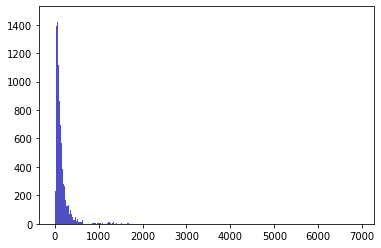

In [98]:
plt.hist(x=cltv_train['Payment'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)